In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
from matplotlib import pyplot
from datasets import load_dataset

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore") 

In [2]:
reviewsData=pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv',nrows=30000)

DATASET_COLUMNS = ["Id", "ProductId", "UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Time", "Summary", "Text"]
reviewsData.columns = DATASET_COLUMNS

In [3]:
reviewsData.drop(['Id', 'ProductId', 'UserId', 'ProfileName' , 'HelpfulnessNumerator' , 'HelpfulnessDenominator', 'Score' ,'Time'],axis = 1 ,inplace = True)

In [4]:
#Reducing the length of dataset for better training and performance
reviewsData.drop_duplicates(subset=['Text'],inplace=True) #Dropping the rows with Duplicates values of 'Text'  
reviewsData.dropna(axis=0,inplace=True) #Dropping the rows with Missing values

In [5]:
#Preprocessing

#This the dictionary used for expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [6]:
#Text Cleaning
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
def text_cleaner(text,num):
    newString = text.lower()  #converts all uppercase characters in the string into lowercase characters and returns it
    newString = BeautifulSoup(newString, "lxml").text #parses the string into an lxml.html 
    newString = re.sub(r'\([^)]*\)', '', newString) #used to replace a string that matches a regular expression instead of perfect match
    newString = re.sub('"','', newString)           
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #for expanding contractions using the contraction_mapping dictionary    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0): 
      tokens = [w for w in newString.split() if not w in stop_words]  #converting the strings into tokens
    else :
      tokens = newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

#Calling the function
cleaned_text = []
for t in reviewsData['Text']:
    cleaned_text.append(text_cleaner(t,0))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Summary Cleaning 
cleaned_summary = []    #Using the text_cleaner function for cleaning summary too
for t in reviewsData['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [8]:
reviewsData['Cleaned_Text'] = cleaned_text  #Adding cleaned text to the dataset
reviewsData['Cleaned_Summary'] = cleaned_summary  #Adding cleaned summary to the dataset
#Dropping Empty Rows
reviewsData['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping rows with Missing values
reviewsData.dropna(axis=0,inplace=True)

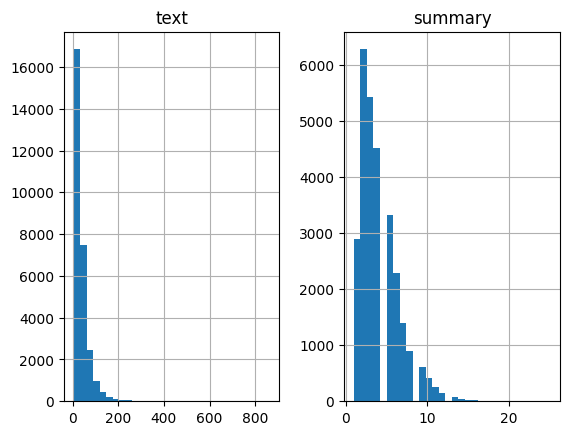

In [9]:
#Data Visualization
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

#Populating the lists with sentence lengths
for i in reviewsData['Cleaned_Text']:
      text_word_count.append(len(i.split()))

for i in reviewsData['Cleaned_Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [10]:
#Function for getting the Maximum Review length  
count=0 
for i in reviewsData['Cleaned_Text']:
    if(len(i.split())<=200):
        count=count+1
print(count/len(reviewsData['Cleaned_Text']))

0.9933337986877007


In [11]:
#Function for getting the Maximum Summary length
count=0
for i in reviewsData['Cleaned_Summary']:
    if(len(i.split())<=15):
        count=count+1
print(count/len(reviewsData['Cleaned_Summary']))

0.9980455116571268


In [12]:
#From the above data we got an idea about maximum lengths of review and summary
max_text_len = 200
max_summary_len = 15

In [13]:
#Adding START and END tags to summary for better decoding
cleaned_text =np.array(reviewsData['Cleaned_Text'])
cleaned_summary=np.array(reviewsData['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [14]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [15]:
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True)

In [16]:
#Preparing Tokenizer

#Text Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#preparing a tokenizer for reviews on training data
X_tokenizer = Tokenizer() 
X_tokenizer.fit_on_texts(list(X_train))

In [17]:
#Rarewords and their coverage in review
thresh = 4  #If a word whose count is less than threshold i.e 4, then it's considered as rare word 

cnt = 0      #denotes no. of rare words whose count falls below threshold
tot_cnt = 0  #denotes size of unique words in the text
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.460098817188204
Total Coverage of rare words: 2.899130527551075


In [18]:
#Defining the Tokenizer with top most common words for reviews

#Preparing a Tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   #provides top most common words
X_tokenizer.fit_on_texts(list(X_train))

#Converting text sequences into integer sequences
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train) 
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

#Padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

#Size of vocabulary (+1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

In [19]:
X_voc

9763

In [20]:
#Summary Tokenizer

#Preparing a Tokenizer for summaries on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [21]:
#Rarewords and their coverage in summary

thresh = 6  ##If a word whose count is less than threshold i.e 6, then it's considered as rare word 

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.36322869955157
Total Coverage of rare words: 7.07565341077461


In [22]:
#Defining Tokenizer with the most common words in summary

#Preparing a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)  #provides top most common words
y_tokenizer.fit_on_texts(list(y_train))

#Converting text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#Padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [23]:
y_voc

1545

In [24]:
#Checking the length of training data
y_tokenizer.word_counts['sostok'],len(y_train)

(22728, 22728)

In [25]:
#Deleting rows containing START and END tokens
#For Training set
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [26]:
#For Validation set
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [27]:
# Model Building
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a.
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        
        # Create trainable weight variables for the layer
        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[0][2], 1),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert isinstance(inputs, list)
        encoder_out_seq, decoder_out_seq = inputs

        if verbose:
            print('encoder_out_seq shape:', encoder_out_seq.shape)
            print('decoder_out_seq shape:', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            # Computing S.Wa where S=[s0, s1, ..., si]
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))

            # Computing hj.Ua
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)

            # tanh(S.Wa + hj.Ua)
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))

            # softmax(va.tanh(S.Wa + hj.Ua))
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        def create_initial_state(inputs, hidden_size):
            # Initial state for K.rnn
            fake_state = K.zeros_like(inputs)
            fake_state = K.sum(fake_state, axis=[1, 2])
            fake_state = K.expand_dims(fake_state)
            fake_state = K.tile(fake_state, [1, hidden_size])
            return fake_state

        fake_state_c = create_initial_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_initial_state(encoder_out_seq, encoder_out_seq.shape[1])

        # Computing energy outputs
        _, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e]
        )

        # Computing context vectors
        _, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        # Output shapes
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [28]:
from tensorflow.keras import backend as K 
K.clear_session()  #Resets all state generated by Keras

latent_dim = 256
embedding_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#Setting up the Decoder using 'encoder_states' as initial state
decoder_inputs = Input(shape=(None,))

#Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#Defining the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 256)  │  2,499,328 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 200,      │    525,312 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 200,      │    525,312 │ lstm[0][0]        │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │    395,520 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 200,      │    525,312 │ lstm_1[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    131,328 │ lstm_2[0][0],     │
│ (AttentionLayer)    │ 256), (None,      │            │ lstm_3[0][0]      │
│                     │ None, 200)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │    792,585 │ concat_layer[0][… │
│ (TimeDistributed)   │ 1545)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,920,009 (22.58 MB)

 Trainable params: 5,920,009 (22.58 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#Adding Metrics
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])
#Adding Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#Training the Model
history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size= 64, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 330s 919ms/step - accuracy: 0.7137 - loss: 2.0726 - val_accuracy: 0.7515 - val_loss: 1.6261
Epoch 2/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 316s 914ms/step - accuracy: 0.7505 - loss: 1.6324 - val_accuracy: 0.7523 - val_loss: 1.5813
Epoch 3/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 912ms/step - accuracy: 0.7501 - loss: 1.6027 - val_accuracy: 0.7530 - val_loss: 1.5521
Epoch 4/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 910ms/step - accuracy: 0.7528 - loss: 1.5536 - val_accuracy: 0.7551 - val_loss: 1.5166
Epoch 5/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 910ms/step - accuracy: 0.7524 - loss: 1.5320 - val_accuracy: 0.7563 - val_loss: 1.4948
Epoch 6/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 322s 911ms/step - accuracy: 0.7541 - loss: 1.5056 - val_accuracy: 0.7594 - val_loss: 1.4665
Epoch 7/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 910ms/step - accuracy: 0.7580 - loss: 1.4634 - val_accuracy: 0.7618 - val_loss: 1.4395
Epoch 8/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 315s 909ms/step - accuracy: 0.7598 -

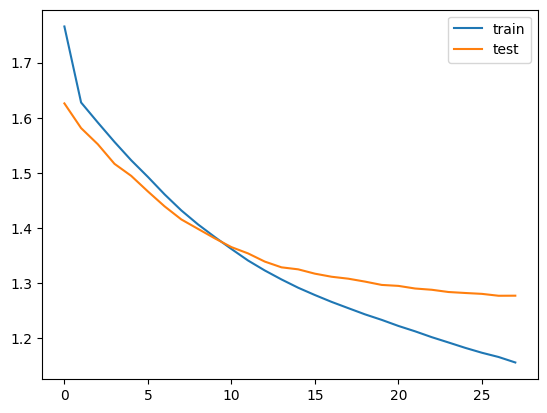

In [30]:
#Visualizing Loss 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [31]:
#Building Dictionary for Source Vocabulary
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [32]:
#Inference/Validation Phase
#Encoding the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder setup
#These tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#Getting the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

#Setting the initial states to the states from the previous time step for better prediction
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

#Final Decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [33]:
#Function defining the implementation of inference process
def decode_sequence(input_seq):
    #Encoding the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    #Populating the first word of target sequence with the start word
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        #Sampling a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index in reverse_target_word_index:
            sampled_token = reverse_target_word_index[sampled_token_index]
        else:
            sampled_token = '<unk>'  # or handle it however you prefer
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        #Exit condition: either hit max length or find stop word
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        #Updating the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #Updating internal states
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
#Functions to convert an integer sequence to a word sequence for summary as well as reviews 
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [35]:
#Summaries generated by the model

for i in range(0,20):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

Review: husband senseo coffee machine used senseo pods okay baronet superb especially decaf 
Original summary: rich delicious coffee 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted summary:  great coffee


Review: normally anything strawberry kiwi flavor tends actually mainly grape juice taste like ripe fruit one absolutely delicious overly sweet actually tastes like fruit pictured like naturally sweetened using corn syrup sweet either tastes like fizzy fresh fruit highly recommended 
Original summary: wow totally natural tasting delicious 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted summary:  not bad


Review: product previously ordered excellent time tasted old hard finally threw away still figured ever got first place ordered another product amazon so

In [36]:
!pip install rouge-score

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=321d727638b44cb4c66d6d71dcc28d665d594c59aefe28b627869e30ce34448e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [37]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(N=20):
    rouge_2 = 0
    rouge_l = 0
    
    # Initialize the ROUGE scorer for ROUGE-2 and ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)

    for i in range(N):
        ref = seq2summary(y_train[i])  # Reference summary
        hypo = decode_sequence(X_train[i].reshape(1, max_text_len))  # Hypothesis generated summary

        # Compute the ROUGE scores
        scores = scorer.score(ref, hypo)

        # Accumulate ROUGE-2 and ROUGE-L F1 scores
        rouge_2 += scores['rouge2'].fmeasure
        rouge_l += scores['rougeL'].fmeasure

    # Average the scores over N examples
    rouge_2_avg = rouge_2 / N
    rouge_l_avg = rouge_l / N
    
    print("ROUGE-2:%.4f ROUGE-L:%.4f" % (rouge_2_avg, rouge_l_avg))

# Call the function to calculate the ROUGE scores
calculate_rouge_scores()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━

### Testing this model on Wikipedia Summary

In [38]:
load_df = pd.read_csv('/kaggle/input/wikipedia-summary/wikipedia_first_10_rows.csv',nrows=5000) 

# Convert the relevant columns to a DataFrame
df2 = pd.DataFrame({'text': load_df['full_text'], 'summary': load_df['summary']})

print(df2.head(5))

                                                                                                                                                                                                      text  \
0  Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over four m...   
1  An astronomer is a scientist in the field of astronomy who focuses their studies on a specific question or field outside the scope of Earth. They observe astronomical objects such as stars, planet...   
2  Alain Connes (; born 1 April 1947) is a French mathematician, and a theoretical physicist, known for his contributions to the study of operator algebras and noncommutative geometry. He is a profes...   
3  International Atomic Time (abbreviated TAI, from its French name Temps atomique 1975) is a high-precision atomic coordinate time standard based on the notional passage of pr

In [39]:
#Reducing the length of dataset for better training and performance
df2.drop_duplicates(subset=['text'],inplace=True) #Dropping the rows with Duplicates values of 'text'  
df2.dropna(axis=0,inplace=True) #Dropping the rows with Missing values

In [40]:
#Calling the function
cleaning_text = []
for t in df2['text']:
    cleaning_text.append(text_cleaner(t,0))

In [41]:
#Summary Cleaning 
cleaning_summary = []    #Using the text_cleaner function for cleaning summary too
for t in df2['summary']:
    cleaning_summary.append(text_cleaner(t,1))

In [42]:
df2['Cleaned_Text'] = cleaning_text  #Adding cleaned text to the dataset
df2['Cleaned_Summary'] = cleaning_summary  #Adding cleaned summary to the dataset
#Dropping Empty Rows
df2['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping rows with Missing values
df2.dropna(axis=0,inplace=True)

In [43]:
wc_text = []
wc_summary = []

#Populating the lists with sentence lengths
for i in df2['Cleaned_Text']:
      wc_text.append(len(i.split()))

for i in df2['Cleaned_Summary']:
      wc_summary.append(len(i.split()))

In [44]:
#Function for getting the Maximum Review length  
count=0 
for i in df2['Cleaned_Text']:
    if(len(i.split())<=200):
        count=count+1
print(count/len(df2['Cleaned_Text']))

0.023


In [45]:
#Function for getting the Maximum Summary length
count=0
for i in df2['Cleaned_Summary']:
    if(len(i.split())<=15):
        count=count+1
print(count/len(df2['Cleaned_Summary']))

0.009


In [46]:
#Adding START and END tags to summary for better decoding
cleanedtext =np.array(df2['Cleaned_Text'])
cleanedsummary=np.array(df2['Cleaned_Summary'])

shorttext=[]
shortsummary=[]

for i in range(len(cleanedtext)):
    if(len(cleanedsummary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        shorttext.append(cleanedtext[i])
        shortsummary.append(cleanedsummary[i])
        
df3=pd.DataFrame({'text':shorttext,'summary':shortsummary})

In [47]:
num_rows = df3.shape[0]
print("Number of rows:", num_rows)

Number of rows: 45


In [48]:
df3['summary'] = df3['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [49]:
# Assign the 'text' column to w_test and 'summary' column to z_test for testing
w_test = np.array(df3['text'])
z_test = np.array(df3['summary'])

In [50]:
w_test_seq   =   X_tokenizer.texts_to_sequences(w_test)
w_test   =   pad_sequences(w_test_seq, maxlen = max_text_len, padding = 'post')

In [51]:
z_test_seq = y_tokenizer.texts_to_sequences(z_test)
z_test = pad_sequences(z_test_seq, maxlen = max_text_len, padding = 'post')

In [52]:
ind=[]
for i in range(len(z_test)):
    cnt=0
    for j in z_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

w_test=np.delete(w_test,ind, axis=0)
z_test=np.delete(z_test,ind, axis=0)

In [53]:
from rouge_score import rouge_scorer

def calculate_rouge_score(N=20):
    rouge_2 = 0
    rouge_l = 0
    
    # Initialize the ROUGE scorer for ROUGE-2 and ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)

    for i in range(N):
        ref = seq2summary(z_test[i])  # Reference summary
        hypo = decode_sequence(w_test[i].reshape(1, max_text_len))  # Hypothesis generated summary

        # Compute the ROUGE scores
        scores = scorer.score(ref, hypo)

        # Accumulate ROUGE-2 and ROUGE-L F1 scores
        rouge_2 += scores['rouge2'].fmeasure
        rouge_l += scores['rougeL'].fmeasure

    # Average the scores over N examples
    rouge_2_avg = rouge_2 / N
    rouge_l_avg = rouge_l / N
    
    print("ROUGE-2:%.4f ROUGE-L:%.4f" % (rouge_2_avg, rouge_l_avg))

# Call the function to calculate the ROUGE scores
calculate_rouge_score()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━